In [1]:
%load_ext lab_black

from ctypes import CDLL, Structure, c_int, c_uint16, c_uint32, c_bool, POINTER
from scipy.io import wavfile
import ctypes
import matplotlib.pyplot as plt
import numpy as np
import os
import serial
import time

In [2]:
base_path = "/tf/notebooks/CEIA/ia-embebida/noise-gate"
assets_path = os.path.join(base_path, "assets")
audios_path = os.path.join(assets_path, "audios")
labels_path = os.path.join(assets_path, "labels")

samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))

data_len = len(data)
duration = data_len / samplerate
print(f"Cantidad de muestras: {data_len}")
print(f"Frecuencia de muestreo: {samplerate} Hz")
print(f"Duracion: {duration:.1f} segundos")
print(f"Valor maximo: {max(data)}")
print(f"Valor minimo: {min(data)}")
print(f"Tipo de dato: {type(data[0])}")

Cantidad de muestras: 956007
Frecuencia de muestreo: 22050 Hz
Duracion: 43.4 segundos
Valor maximo: 32767
Valor minimo: -32768
Tipo de dato: <class 'numpy.int16'>


/tmp/ipykernel_356/2236063515.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(os.path.join(audios_path, "recording_01.wav"))


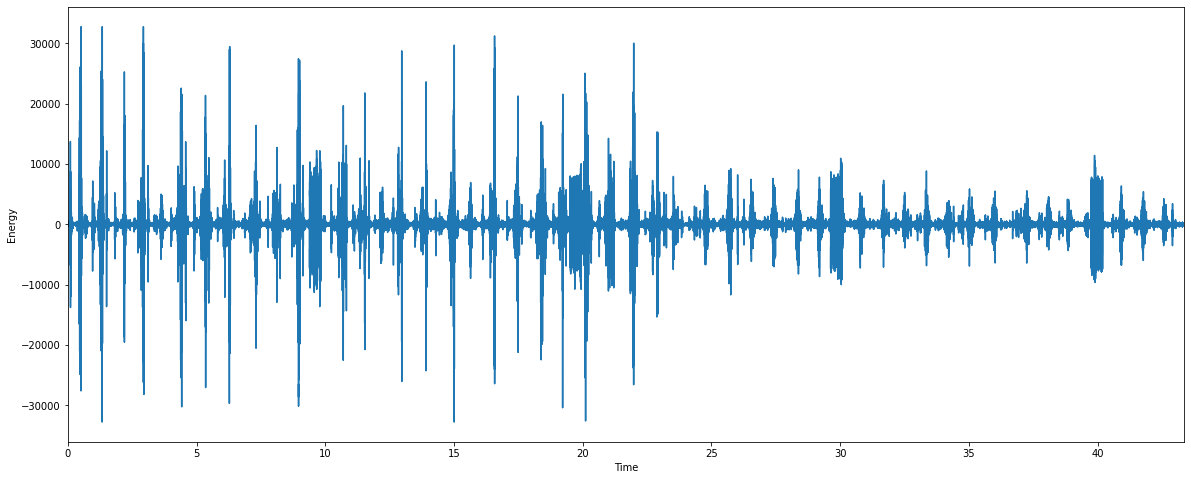

In [3]:
timeline = np.linspace(0, duration, num=data_len)

plt.figure(figsize=(20, 8))
plt.plot(timeline, data)
plt.xlabel("Time")
plt.xlim([0, duration])
plt.ylabel("Energy")
plt.show()

In [4]:
events = []

with open(os.path.join(labels_path, "recording_01.txt")) as f:
    for line in f.readlines():
        events.append(line.split())

events

[['0.240503', '0.840503', 'bite'],
 ['1.009850', '1.649850', 'bite'],
 ['1.962504', '2.482504', 'bite'],
 ['2.640000', '3.240000', 'chewbite'],
 ['3.360000', '4.000000', 'chew'],
 ['4.120000', '4.760000', 'chewbite'],
 ['5.040000', '5.680000', 'chewbite'],
 ['5.920000', '6.640000', 'chewbite'],
 ['6.880000', '7.600000', 'chewbite'],
 ['7.760000', '8.480000', 'chew'],
 ['8.560000', '9.280000', 'chewbite'],
 ['9.353957', '9.967811', 'chew'],
 ['10.320000', '10.960000', 'chewbite'],
 ['11.160000', '11.800000', 'chewbite'],
 ['11.920000', '12.600000', 'chew'],
 ['12.680000', '13.320000', 'chewbite'],
 ['13.560000', '14.200000', 'chewbite'],
 ['14.440000', '15.280000', 'chewbite'],
 ['15.360000', '16.040000', 'chew'],
 ['16.240000', '16.800000', 'chewbite'],
 ['17.160000', '17.800000', 'chewbite'],
 ['18.120000', '18.760000', 'chewbite'],
 ['18.896399', '19.585795', 'bite'],
 ['19.800000', '20.480000', 'chewbite'],
 ['20.761400', '21.280253', 'chew'],
 ['21.624225', '22.280000', 'chewbite']

In [5]:
def normalize(value, value_max=32767, value_min=-32768):
    return (value - value_min) / (value_max - value_min)


class NoiseGate:
    def __init__(self, open, close, hold, samplerate):
        self._open = normalize(open) * normalize(open)
        self._close = normalize(close) * normalize(close)
        self._samples_hold = int(hold * samplerate)
        self._is_open = False
        self._last_idx_open = 0
        self._index = 0

    def transform(self, sample):
        sample_norm = normalize(sample.astype("float"))
        sample_square = sample_norm * sample_norm

        if sample_square >= self._open:
            self._is_open = True
            self._last_idx_open = self._index
        elif (
            self._is_open
            and sample_square < self._close
            and self._index > self._last_idx_open + self._samples_hold
        ):
            self._is_open = False

        self._index += 1

        return sample if self._is_open else 0

In [6]:
def get_from_events(data, samplerate, events):
    out = np.zeros_like(data)
    for event in events:
        start = int(float(event[0]) * samplerate)
        end = int(float(event[1]) * samplerate)
        out[start:end] = data[start:end]
    return out


filtered_by_events = get_from_events(data, samplerate, events)

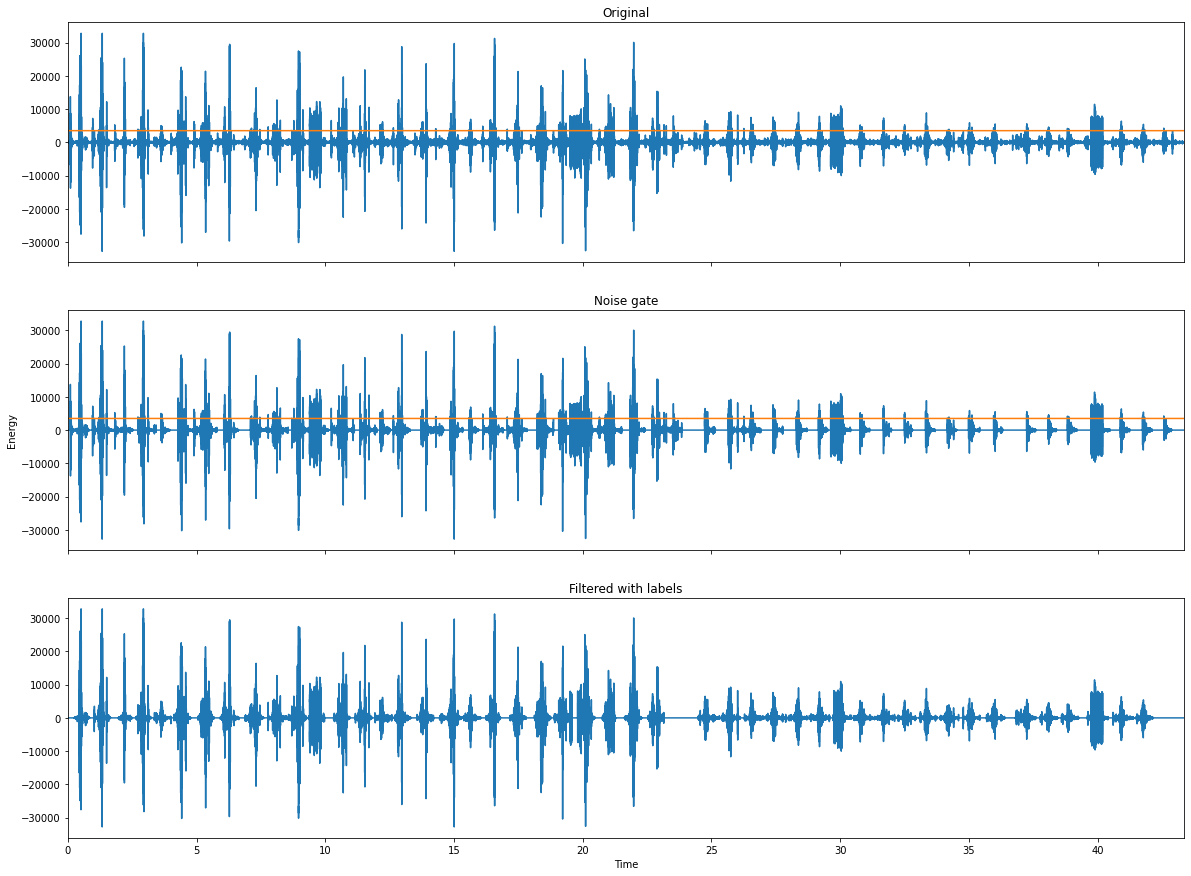

In [7]:
OPEN_LIMIT = 3500
CLOSE_LIMIT = 300
HOLD = 0.3

noise_gate = NoiseGate(OPEN_LIMIT, CLOSE_LIMIT, HOLD, samplerate)
results_noise_gate = [noise_gate.transform(value) for value in data]
threshold = np.ones_like(data) * OPEN_LIMIT

f, axes = plt.subplots(3, sharex=True, figsize=(20, 15))

axes[0].plot(timeline, data)
axes[0].plot(timeline, threshold)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(timeline, results_noise_gate)
axes[1].plot(timeline, threshold)
axes[1].set_xlim([0, duration])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

axes[2].plot(timeline, filtered_by_events)
axes[2].set_xlim([0, duration])
axes[2].set_title("Filtered with labels")
axes[2].set_xlabel("Time")

f.show()

In [8]:
class Config(Structure):
    _fields_ = [
        ("open", c_uint16),
        ("close", c_uint16),
        ("samplesHold", c_uint32),
        ("openCounter", c_uint32),
        ("isOpen", c_bool),
    ]


library_path = os.path.join(base_path, "cfunctions.c")
library_path_obj = os.path.join(base_path, "cfunctions.so")

!gcc -fPIC -shared -o $library_path_obj $library_path

cfunctions = CDLL(library_path_obj)

c_to_uint16 = cfunctions.toUint16
c_to_uint16.argtypes = [c_int]
c_to_uint16.restype = c_uint16

c_noise_gate = cfunctions.noiseGate
c_noise_gate.argtypes = [c_uint16, POINTER(Config)]
c_noise_gate.restype = c_bool

In [9]:
class CNoiseGate:
    def __init__(self, open, close, hold, samplerate):
        self.idx = 0
        self.config = Config(
            open=c_to_uint16(open),
            close=c_to_uint16(close),
            samplesHold=int(hold * samplerate),
            openCounter=0,
            isOpen=False,
        )

    def transform(self, sample):
        is_open = c_noise_gate(c_to_uint16(sample), self.config)
        return sample if is_open else 0

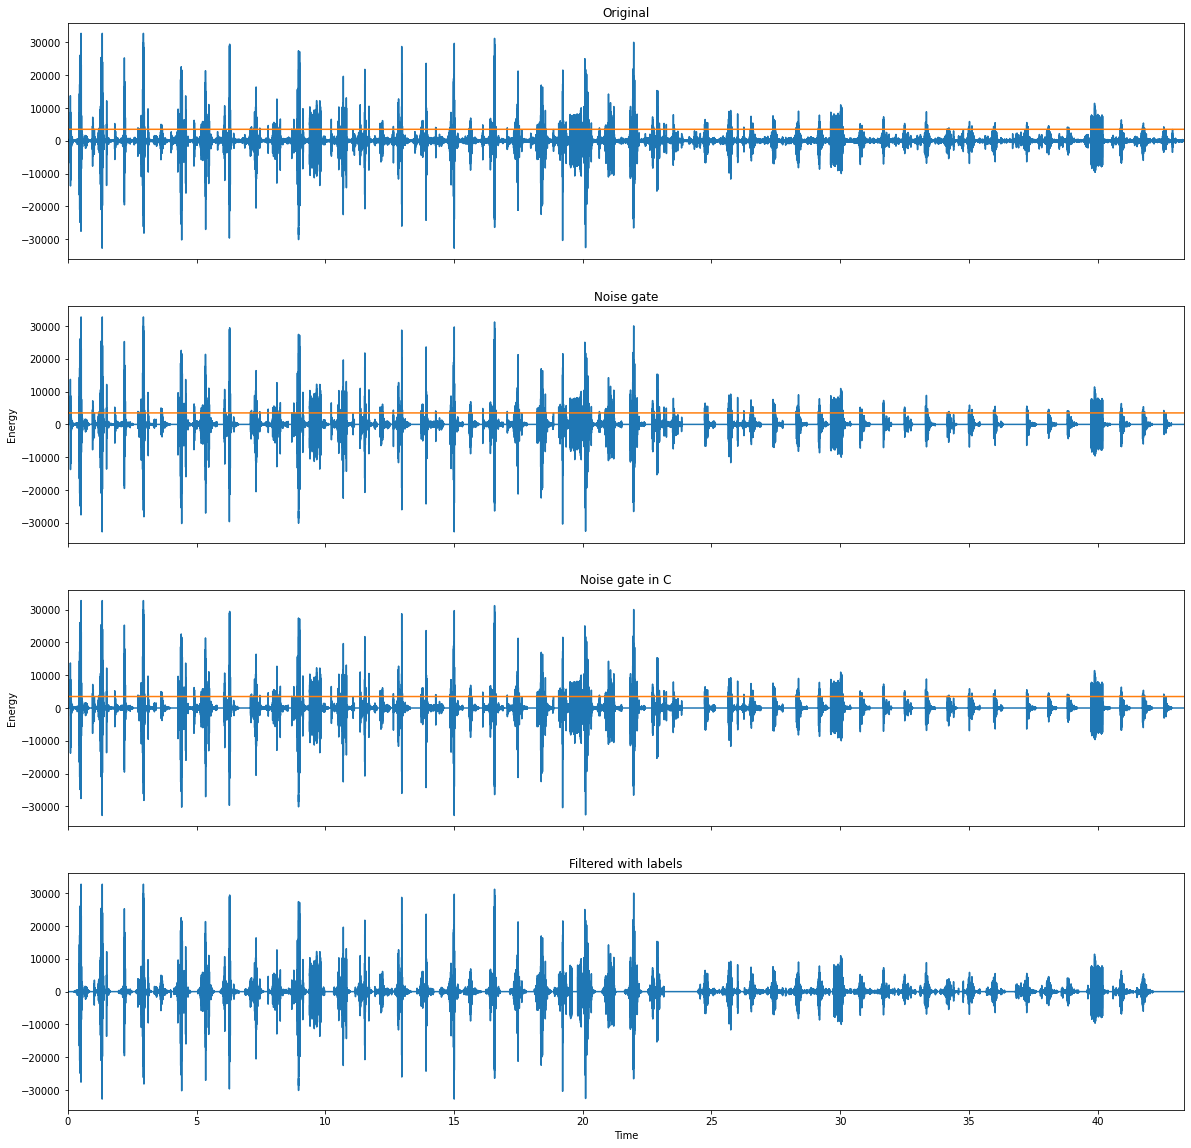

In [10]:
test_c_noise_gate = CNoiseGate(OPEN_LIMIT, CLOSE_LIMIT, HOLD, samplerate)
results_c_noise_gate = [test_c_noise_gate.transform(value) for value in data]

f, axes = plt.subplots(4, sharex=True, figsize=(20, 20))

axes[0].plot(timeline, data)
axes[0].plot(timeline, threshold)
axes[0].set_xlim([0, duration])
axes[0].set_title("Original")

axes[1].plot(timeline, results_noise_gate)
axes[1].plot(timeline, threshold)
axes[1].set_xlim([0, duration])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

axes[2].plot(timeline, results_c_noise_gate)
axes[2].plot(timeline, threshold)
axes[2].set_xlim([0, duration])
axes[2].set_title("Noise gate in C")
axes[2].set_ylabel("Energy")

axes[3].plot(timeline, filtered_by_events)
axes[3].set_xlim([0, duration])
axes[3].set_title("Filtered with labels")
axes[3].set_xlabel("Time")

f.show()

In [11]:
np.array_equal(results_noise_gate, results_c_noise_gate)

True

In [15]:
PORT = "/dev/ttyUSB0"
BAUD_RATE = 115200

SAMPLES = 200000

serial_port = serial.Serial(PORT, BAUD_RATE, timeout=0.25)
serial_port.flushInput()

results_esp = []
for value in data[:SAMPLES]:
    data_uint = int(value) + 32768
    serial_port.write(data_uint.to_bytes(2, "little"))
    # time.sleep(0.5)
    bytes = serial_port.read(2)
    result = int.from_bytes(bytes, "little")
    result -= 32768
    results_esp.append(result)

serial_port.close()

In [16]:
np.array_equal(results_esp, results_c_noise_gate[:SAMPLES])

True

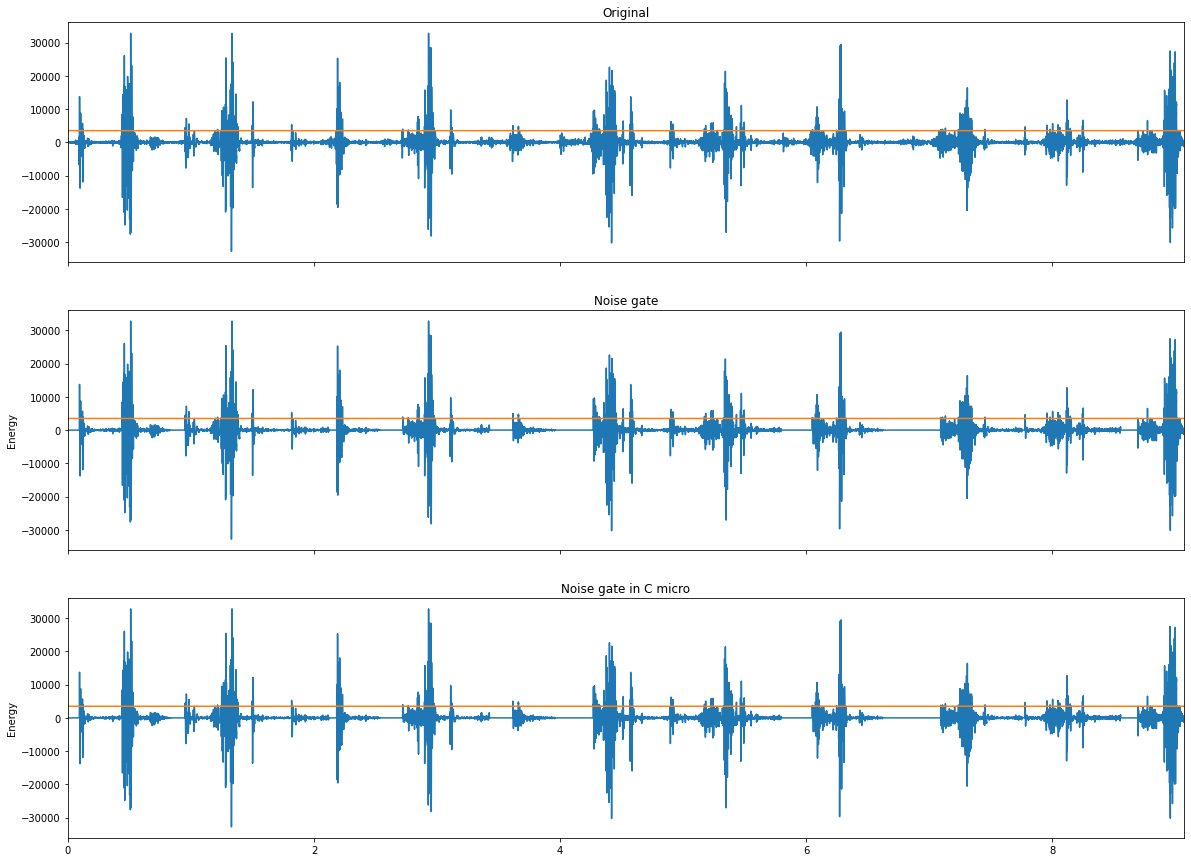

In [17]:
f, axes = plt.subplots(3, sharex=True, figsize=(20, 15))

timeline_sample = timeline[:SAMPLES]
duration_sample = SAMPLES / samplerate
threshold_sample = np.ones_like(timeline_sample) * OPEN_LIMIT

axes[0].plot(timeline_sample, data[:SAMPLES])
axes[0].plot(timeline_sample, threshold_sample)
axes[0].set_xlim([0, duration_sample])
axes[0].set_title("Original")

axes[1].plot(timeline_sample, results_noise_gate[:SAMPLES])
axes[1].plot(timeline_sample, threshold_sample)
axes[1].set_xlim([0, duration_sample])
axes[1].set_title("Noise gate")
axes[1].set_ylabel("Energy")

axes[2].plot(timeline_sample, results_esp)
axes[2].plot(timeline_sample, threshold_sample)
axes[2].set_xlim([0, duration_sample])
axes[2].set_title("Noise gate in C micro")
axes[2].set_ylabel("Energy")

f.show()